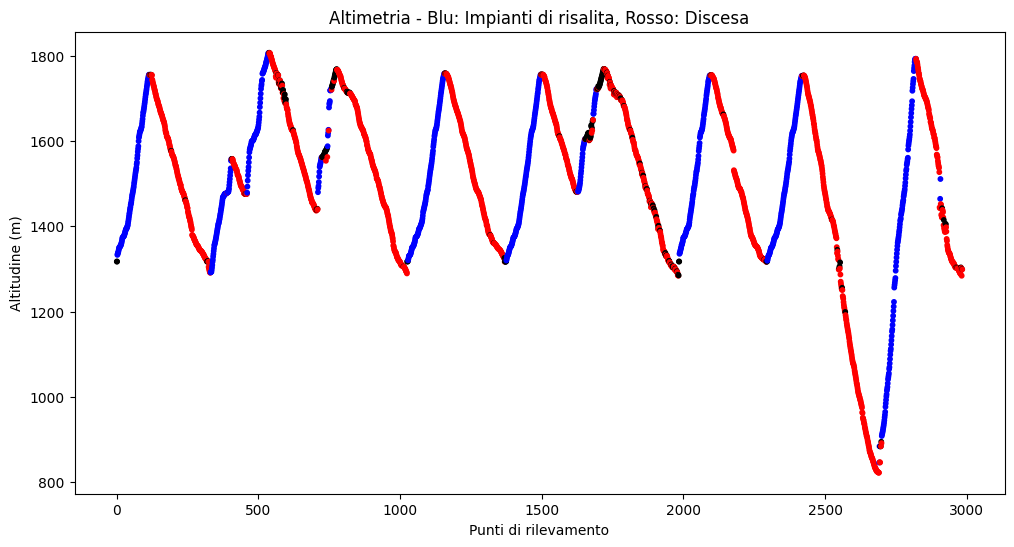

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il dataset
df = pd.read_csv("data/gdf1.csv")

# Definisce i criteri per una salita sugli impianti
soglia_dislivello = 50  # Minimo dislivello per considerare un impianto

# Identifica i punti in salita (distanza verticale > 0)
df["is_ascent"] = df["distanza_verticale"] > 0

# Raggruppa segmenti continui di salita
df["ascent_group"] = (df["is_ascent"] != df["is_ascent"].shift()).cumsum()
gruppi = df[df["is_ascent"]].groupby("ascent_group")["distanza_verticale"].sum()

# Seleziona solo i segmenti con almeno 50m di dislivello
valid_groups = gruppi[gruppi >= soglia_dislivello].index
df["on_lift"] = df["ascent_group"].isin(valid_groups)

# Assegna i colori: blu per impianti di risalita, rosso per discesa, nero per il resto
df["color"] = df.apply(lambda row: "blue" if row["on_lift"] else "red" if row["distanza_verticale"] < 0 else "black", axis=1)

# Plotta l'altimetria
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df["altitudine"], c=df["color"], s=10)
plt.xlabel("Punti di rilevamento")
plt.ylabel("Altitudine (m)")
plt.title("Altimetria - Blu: Impianti di risalita, Rosso: Discesa")
plt.show()


/tmp/ipykernel_62408/4177940349.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(salite_finali))


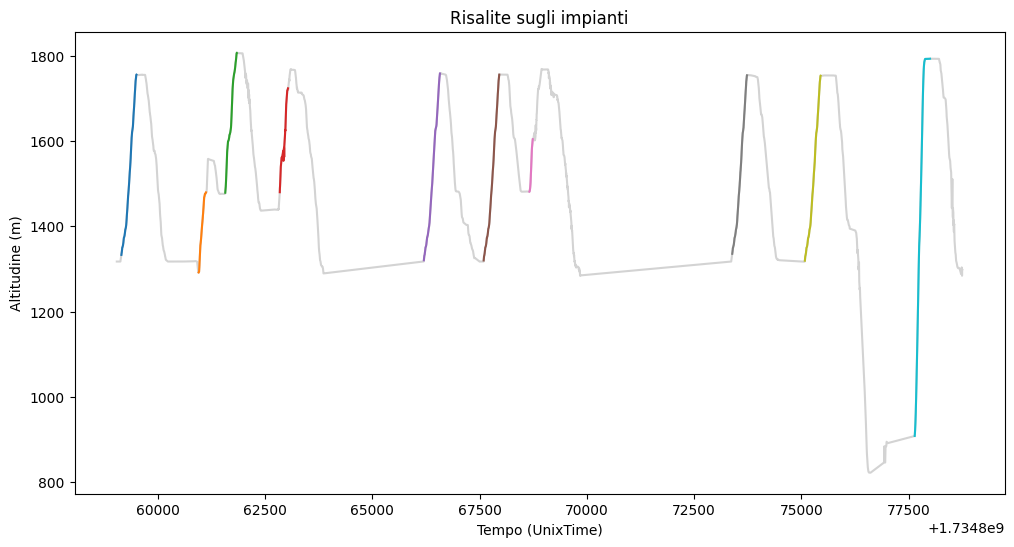

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carica il dataset
#df = pd.read_csv("dataset.csv")

# Soglie
soglia_dislivello = 90  # Minimo dislivello per considerare una risalita
soglia_cluster_temporale = 300  # Tempo massimo tra due segmenti per fonderli (es. 5 min)

# Identifica punti in salita
df["is_ascent"] = df["distanza_verticale"] > 0

# Raggruppa segmenti continui di salita
df["ascent_group"] = (df["is_ascent"] != df["is_ascent"].shift()).cumsum()

# Calcola il dislivello totale per ogni gruppo
gruppi = df[df["is_ascent"]].groupby("ascent_group").agg({
    "unixtime": ["min", "max"],
    "distanza_verticale": "sum"
}).reset_index()

# Seleziona solo le salite valide
gruppi.columns = ["ascent_group", "start_time", "end_time", "total_vertical"]
salite = gruppi[gruppi["total_vertical"] >= soglia_dislivello].copy()

# Clusterizza risalite vicine nel tempo
salite["cluster"] = (salite["start_time"] - salite["end_time"].shift(1) > soglia_cluster_temporale).cumsum()

# Raggruppa i cluster
salite_finali = salite.groupby("cluster").agg({
    "start_time": "min",
    "end_time": "max",
    "total_vertical": "sum"
}).reset_index()

# PLot Altimetria con colori diversi per ogni salita
plt.figure(figsize=(12, 6))

# Genera una palette di colori
colors = plt.cm.get_cmap("tab10", len(salite_finali))

# Disegna la traccia completa in grigio chiaro
plt.plot(df["unixtime"], df["altitudine"], color="lightgray", label="Traccia completa")

# Plotta ogni salita con un colore diverso
for i, row in salite_finali.iterrows():
    mask = (df["unixtime"] >= row["start_time"]) & (df["unixtime"] <= row["end_time"])
    plt.plot(df[mask]["unixtime"], df[mask]["altitudine"], color=colors(i), label=f"Salita {i+1}")

plt.xlabel("Tempo (UnixTime)")
plt.ylabel("Altitudine (m)")
plt.title("Risalite sugli impianti")
#plt.legend()
plt.show()


/tmp/ipykernel_62408/1260734979.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(salite_finali))


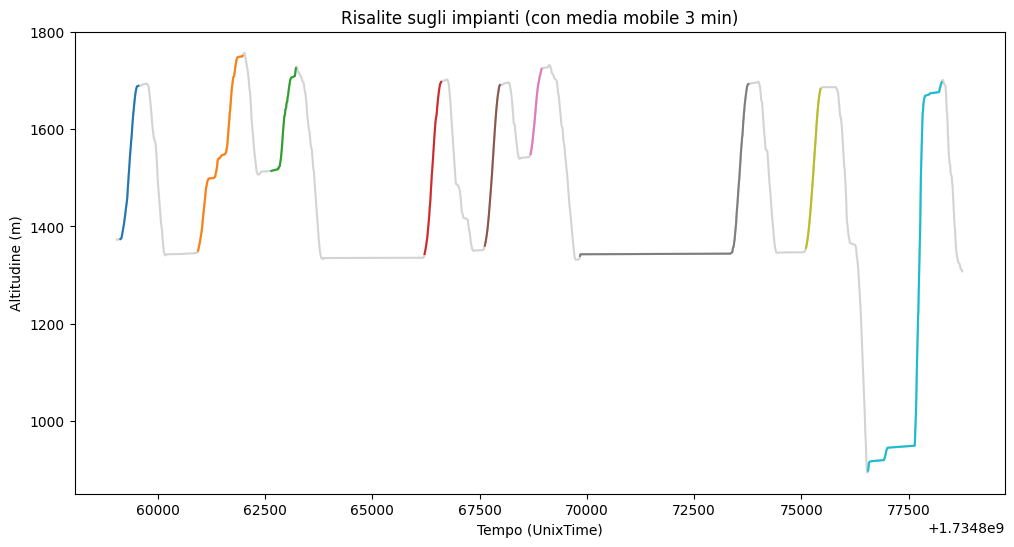

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carica il dataset
#df = pd.read_csv("dataset.csv")

# Soglie di filtraggio
soglia_dislivello = 90       # Minimo dislivello per considerare una risalita
soglia_cluster_temporale = 400  # Tempo massimo tra due segmenti per fonderli (5 min)
soglia_durata = 30           # Tempo minimo di una risalita in secondi
soglia_variazione_alt = 1    # Scarta variazioni di quota minime tra punti
finestra_media_mobile = 90  # Finestra di 3 minuti (180 secondi)

# **1. Calcolo della media mobile sull'altitudine**
df["altitudine_media_mobile"] = df["altitudine"].rolling(window=finestra_media_mobile, min_periods=3, center=True).mean()

# **2. Calcola la distanza verticale basata sulla media mobile**
df["distanza_verticale_media_mobile"] = df["altitudine_media_mobile"].diff().fillna(0)

# **3. Identifica punti in salita (ignorando variazioni minime)**
df["is_ascent"] = df["distanza_verticale_media_mobile"] > soglia_variazione_alt

# **4. Raggruppa segmenti continui di salita**
df["ascent_group"] = (df["is_ascent"] != df["is_ascent"].shift()).cumsum()

# **5. Calcola statistiche per ogni salita**
gruppi = df[df["is_ascent"]].groupby("ascent_group").agg({
    "unixtime": ["min", "max"],
    "distanza_verticale_media_mobile": "sum"
}).reset_index()

# **6. Seleziona solo le salite valide**
gruppi.columns = ["ascent_group", "start_time", "end_time", "total_vertical"]
salite = gruppi[(gruppi["total_vertical"] >= soglia_dislivello) & 
                ((gruppi["end_time"] - gruppi["start_time"]) >= soglia_durata)].copy()

# **7. Clusterizza salite vicine nel tempo**
salite["cluster"] = (salite["start_time"] - salite["end_time"].shift(1) > soglia_cluster_temporale).cumsum()

# **8. Raggruppa i cluster finali**
salite_finali = salite.groupby("cluster").agg({
    "start_time": "min",
    "end_time": "max",
    "total_vertical": "sum"
}).reset_index()

# **9. Plot con colori diversi per ogni salita**
plt.figure(figsize=(12, 6))

# Colori diversi per ogni salita
colors = plt.cm.get_cmap("tab10", len(salite_finali))

# Traccia completa in grigio chiaro
plt.plot(df["unixtime"], df["altitudine_media_mobile"], color="lightgray", label="Altitudine (media mobile)")

# Plotta ogni salita con un colore diverso
for i, row in salite_finali.iterrows():
    mask = (df["unixtime"] >= row["start_time"]) & (df["unixtime"] <= row["end_time"])
    plt.plot(df[mask]["unixtime"], df[mask]["altitudine_media_mobile"], color=colors(i), label=f"Salita {i+1}")

plt.xlabel("Tempo (UnixTime)")
plt.ylabel("Altitudine (m)")
plt.title("Risalite sugli impianti (con media mobile 3 min)")
#plt.legend()
plt.show()


/tmp/ipykernel_62408/3304727256.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(salite_finali))


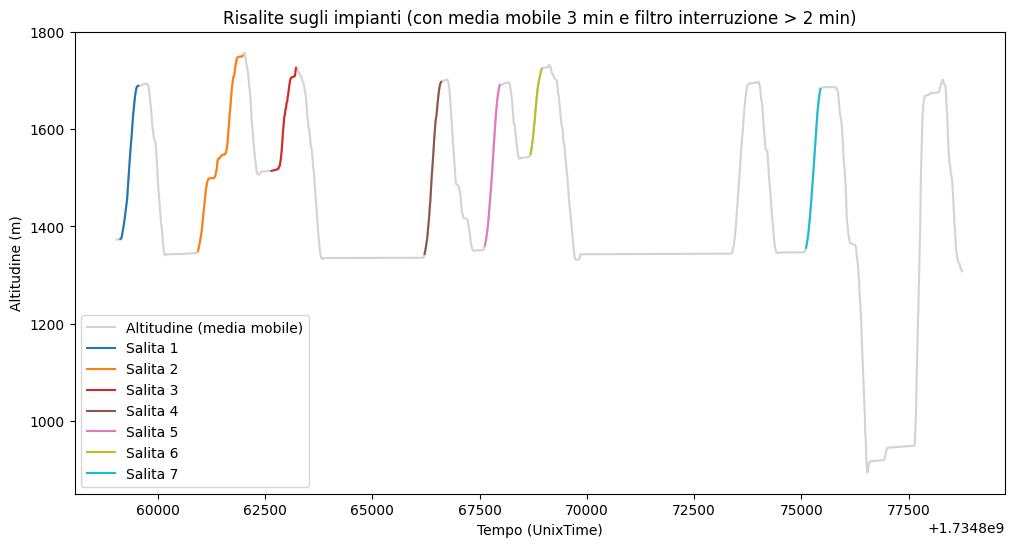

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carica il dataset
#df = pd.read_csv("dataset.csv")

# Soglie di filtraggio

soglia_interruzione = 600    # Massimo 2 minuti senza dati per non considerare la risalita (in secondi)

soglia_dislivello = 90       # Minimo dislivello per considerare una risalita
soglia_cluster_temporale = 400  # Tempo massimo tra due segmenti per fonderli (5 min)
soglia_durata = 30           # Tempo minimo di una risalita in secondi
soglia_variazione_alt = 1    # Scarta variazioni di quota minime tra punti
finestra_media_mobile = 90  # Finestra di 3 minuti (180 secondi)

# **1. Calcolo della media mobile sull'altitudine**
df["altitudine_media_mobile"] = df["altitudine"].rolling(window=finestra_media_mobile, min_periods=1, center=True).mean()

# **2. Calcola la distanza verticale basata sulla media mobile**
df["distanza_verticale_media_mobile"] = df["altitudine_media_mobile"].diff().fillna(0)

# **3. Identifica punti in salita (ignorando variazioni minime)**
df["is_ascent"] = df["distanza_verticale_media_mobile"] > soglia_variazione_alt

# **4. Calcola il delta temporale tra punti consecutivi**
df["delta_tempo"] = df["unixtime"].diff().fillna(0)

# **5. Raggruppa segmenti continui di salita**
df["ascent_group"] = (df["is_ascent"] != df["is_ascent"].shift()).cumsum()

# **6. Calcola statistiche per ogni salita**
gruppi = df[df["is_ascent"]].groupby("ascent_group").agg({
    "unixtime": ["min", "max"],
    "distanza_verticale_media_mobile": "sum",
    "delta_tempo": "max"  # Considera anche la durata massima dell'interruzione
}).reset_index()

# **7. Seleziona solo le salite valide**
gruppi.columns = ["ascent_group", "start_time", "end_time", "total_vertical", "max_delta_tempo"]
salite = gruppi[(gruppi["total_vertical"] >= soglia_dislivello) & 
                ((gruppi["end_time"] - gruppi["start_time"]) >= soglia_durata) & 
                (gruppi["max_delta_tempo"] <= soglia_interruzione)].copy()

# **8. Clusterizza salite vicine nel tempo**
salite["cluster"] = (salite["start_time"] - salite["end_time"].shift(1) > soglia_cluster_temporale).cumsum()

# **9. Raggruppa i cluster finali**
salite_finali = salite.groupby("cluster").agg({
    "start_time": "min",
    "end_time": "max",
    "total_vertical": "sum"
}).reset_index()

# **10. Plot con colori diversi per ogni salita**
plt.figure(figsize=(12, 6))

# Colori diversi per ogni salita
colors = plt.cm.get_cmap("tab10", len(salite_finali))

# Traccia completa in grigio chiaro
plt.plot(df["unixtime"], df["altitudine_media_mobile"], color="lightgray", label="Altitudine (media mobile)")

# Plotta ogni salita con un colore diverso
for i, row in salite_finali.iterrows():
    mask = (df["unixtime"] >= row["start_time"]) & (df["unixtime"] <= row["end_time"])
    plt.plot(df[mask]["unixtime"], df[mask]["altitudine_media_mobile"], color=colors(i), label=f"Salita {i+1}")

plt.xlabel("Tempo (UnixTime)")
plt.ylabel("Altitudine (m)")
plt.title("Risalite sugli impianti (con media mobile 3 min e filtro interruzione > 2 min)")
plt.legend()
plt.show()
